In [1]:
import sys

if not 'pandas' in sys.modules:
    !pip install -U 'pandas'==1.5.3
if not 'numpy' in sys.modules:
    !pip install -U 'numpy'==1.24.4
if not 'os' in sys.modules:
    !pip install -U 'os'       
if not 'glob' in sys.modules:
    !pip install -U 'glob'       
if not 'matplotlib' in sys.modules:
    !pip install -U 'matplotlib'      
if not 'seaborn' in sys.modules:
    !pip install -U 'seaborn'          
if not 're' in sys.modules:
    !pip install -U 're'   
if not 'scipy' in sys.modules:
    !pip install -U 'scipy'
if not 'scikit-learn' in sys.modules:
    !pip install -U 'scikit-learn'
if not 'haversine' in sys.modules:
    !pip install -U 'haversine'   
if not 'pyarrow' in sys.modules:
    !pip install -U 'pyarrow' 
if not 'folium' in sys.modules:
    !pip install -U 'folium' 
if not 'webbrowser' in sys.modules:
    !pip install -U 'webbrowser' 
if not 'geopandas' in sys.modules:
    !pip install -U 'geopandas' 

ERROR: Could not find a version that satisfies the requirement webbrowser (from versions: none)
ERROR: No matching distribution found for webbrowser


In [2]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy
from haversine import haversine, Unit
from os.path import join
from pathlib import Path
import folium
import webbrowser as web
import geopandas as gpd
from folium import plugins

<h3>Global parameters</h3>
<ul>
    <li>Day [day]</li>
    <li>Time Window [tw]</li>
    <li>Connection duration [cd]</li>
    <li>Walking speed [ws]</li>
</ul>

In [3]:
day = 11
tw = 5
cd = [30, 1200]
ws = 1

<h3>Load tracking events and bus stop data</h3>
<p>Each event is a log that marks the passage of a bus through a bus stop. Firstly, everything is loaded, and second it is filtered from 6:00 to 19:59.</p>

In [4]:
def extract_terminal_name(x):
    if isinstance(x, str):
        pattern = r'Terminal (Capão da Imbuia|Pinheirinho|Portão|Bairro Alto|Barreirinha|Boa Vista|Boqueirão|Cabral|Cachoeira|Caiuá|Campina do Siqueira|Campo Comprido|Capão Raso|Carmo|Centenário|CIC|Fazendinha|Hauer|Maracanã|Oficinas|Pinhais|Santa Cândida|Santa Felicidade|Sítio Cercado|Tatuquara)'

        match = re.search(pattern, x)
        if match:
            return match.group()
    return x

# ----------------------------------------------------------
# Tracking events
# ----------------------------------------------------------
vw_event = pd.read_parquet("vw_event.parquet")
vw_event['hour'] = vw_event["event_timestamp"].dt.hour
vw_event['base_date'] = pd.to_datetime(vw_event["base_date"])
vw_event.query("6 <= hour <= 19", inplace = True)

# ----------------------------------------------------------
# Bus stops + normalization of names
# ----------------------------------------------------------
dim_bus_stop = pd.read_parquet("dim_bus_stop.parquet").query("type_norm not in (['Others','Dawn bus','Tourism line'])").drop(columns=['last_update'])
dim_bus_stop['name_normalized'] = np.where((dim_bus_stop.type_norm == 'Bus terminal'), dim_bus_stop.name, '')
dim_bus_stop['name_normalized'] = dim_bus_stop['name_normalized'].apply(extract_terminal_name)
dim_bus_stop['type_norm'] = np.where((dim_bus_stop.type_norm == 'Bus terminal'), 'Tube station', dim_bus_stop.type_norm)
terminais_dummy_ids = dim_bus_stop.query("~name_normalized.isna() and name_normalized != ''").groupby(['name_normalized']).agg(dummy_legacy_id = ('legacy_id', 'sum')).reset_index()
dim_bus_stop = dim_bus_stop.merge(terminais_dummy_ids, on=['name_normalized'], how='left')
dim_bus_stop['dummy_legacy_id'] = np.where( (dim_bus_stop.name_normalized == '') , dim_bus_stop.legacy_id, dim_bus_stop.dummy_legacy_id)
dim_bus_stop['dummy_legacy_id'] = dim_bus_stop.dummy_legacy_id.astype(int)

# ----------------------------------------------------------
# Consolidation of events + normalized points
# ----------------------------------------------------------
bs = dim_bus_stop.copy()
bs['name_normalized'] = np.where((bs.name_normalized == ''), bs.name, bs.name_normalized)
bs = bs.filter(['dummy_legacy_id', 'name_normalized', 'type_norm', 'latitude', 'longitude']).groupby(by = ['dummy_legacy_id', 'name_normalized', 'type_norm']).agg({'latitude': 'mean', 'longitude': 'mean'}).reset_index()
b = pd.merge(vw_event.filter(['line_code', 'itinerary_id', 'vehicle', 'legacy_id', 'seq', 'event_timestamp', 'base_date', 'month', 'day', 'weekday', 'hour']), dim_bus_stop.filter(['legacy_id', 'dummy_legacy_id']), left_on = 'legacy_id', right_on = 'legacy_id', how = 'left').drop(columns = ['legacy_id'])
events = pd.merge(b, bs)
events.dummy_legacy_id = events.dummy_legacy_id.astype('int')
events['year'] = events['event_timestamp'].dt.year
events['month'] = events['event_timestamp'].dt.month
events['day'] = events['event_timestamp'].dt.day
events['weekday'] = events['event_timestamp'].dt.weekday
events['hour'] = events['event_timestamp'].dt.hour
conditions = [
    ((events.hour >= 6) & ((events.hour <= 8))),
    ((events.hour >= 11) & ((events.hour <= 13))),
    ((events.hour >= 17) & ((events.hour <= 19)))
]
period_choices = ['Morning', 'Midday', 'Evening']
events['period'] = np.select(conditions, period_choices, default = 'N/A')
events.query(f'day == {day}', inplace = True)

<h3>Compute bus service</h3>
<p>The bus service is evaluated in a time window of <b>tw</b> minutes, representing an expected waiting time for most users. The number of buses of a line code that pass a stop is counted considering a time windows of <b>tw</b> minutes. This way, buses within a time window of <b>tw</b> minutes are counted. For each combination of bus stop and line code, a time series represents the number of buses observed in a <b>tw</b>-minute time interval during the day.</p>

In [5]:
events['time_window'] = (60 * events["event_timestamp"].dt.hour + events["event_timestamp"].dt.minute).floordiv(tw)
df_bus_availability = events.groupby(['dummy_legacy_id','line_code','year','month','day','weekday','hour','time_window']).size().reset_index(name = 'bus_count')
dim_bus_stop = events.filter(['dummy_legacy_id','line_code']).drop_duplicates()
dim_time = events.filter(['year','month','day','weekday','hour','time_window']).drop_duplicates()
df_bus_availability = pd.merge(pd.merge(dim_bus_stop, dim_time, how = 'cross'), df_bus_availability, how = 'left').fillna(0)
df_bus_availability = pd.merge(df_bus_availability, bs, on = "dummy_legacy_id")
period_choices = ['Morning', 'Midday', 'Evening']
conditions = [
    ((df_bus_availability.hour >= 6) & ((df_bus_availability.hour <= 8))),
    ((df_bus_availability.hour >= 11) & ((df_bus_availability.hour <= 13))),
    ((df_bus_availability.hour >= 17) & ((df_bus_availability.hour <= 19)))
]
df_bus_availability['period'] = np.select(conditions, period_choices, default = 'N/A')

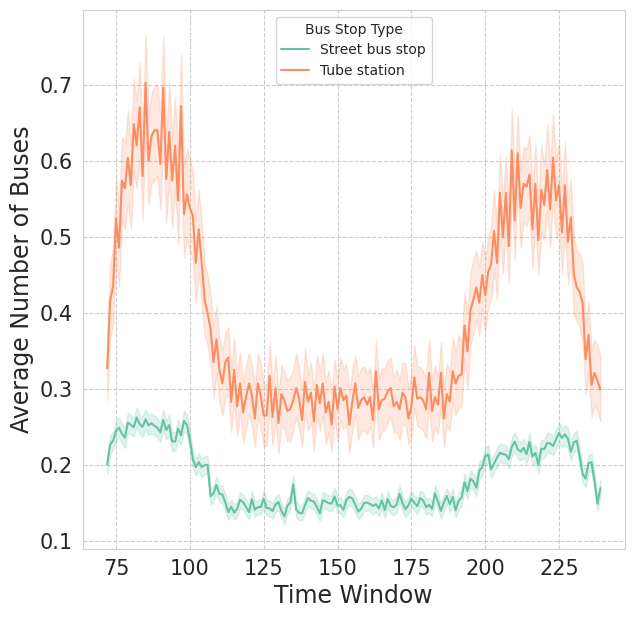

In [7]:
fig, axes = plt.subplots(figsize = (7, 7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.lineplot(x = df_bus_availability.time_window, y = df_bus_availability.bus_count, estimator = 'mean', errorbar = ('ci', 95), hue = df_bus_availability.type_norm, legend = True, palette = sns.color_palette("Set2", 2))
g.tick_params(labelsize = 15)
g.set_ylabel("Average Number of Buses", fontsize = 17)
g.set_xlabel("Time Window", fontsize = 17)
plt.legend(title = 'Bus Stop Type', loc = 'upper center');

<h3>Positive edges loading</h3>
<p>Firstly, everything is loaded, and second it is tagged by period:</p>
<ul>
    <li>Morning: 6:00 to 8:59 am</li>
    <li>Midday: 11:00 to 13:59</li>
    <li>Evening: 17:00 to 19:59</li>

In [8]:
parquet_files = glob.glob("connections_20min/*.parquet")
positive_edges = [pd.read_parquet(f) for f in parquet_files]
positive_edges = pd.concat(positive_edges, ignore_index = True)
positive_edges['event_timestamp_u'] =  pd.to_datetime(positive_edges["event_timestamp_u"])
positive_edges['event_timestamp_v'] =  pd.to_datetime(positive_edges["event_timestamp_v"])
positive_edges = positive_edges.groupby(by = ['dummy_legacy_id_u', 'dummy_legacy_id_v', 'line_code_u', 'line_code_v', 'vehicle_u', 'vehicle_v', 'event_timestamp_u']).event_timestamp_v.max().reset_index()
positive_edges['year'] = positive_edges['event_timestamp_u'].dt.year
positive_edges['month'] = positive_edges['event_timestamp_u'].dt.month
positive_edges['day'] = positive_edges['event_timestamp_u'].dt.day
positive_edges['weekday'] = positive_edges['event_timestamp_u'].dt.weekday
positive_edges['hour'] = positive_edges['event_timestamp_u'].dt.hour
positive_edges['base_date'] = pd.to_datetime(dict(year=positive_edges.year, month=positive_edges.month, day=positive_edges.day))
positive_edges['duration'] = (positive_edges.event_timestamp_v - positive_edges.event_timestamp_u).astype('timedelta64[s]')
positive_edges.drop_duplicates(inplace = True)

conditions = [
    ((positive_edges.event_timestamp_v.dt.hour >= 6) & ((positive_edges.event_timestamp_v.dt.hour <= 8))),
    ((positive_edges.event_timestamp_v.dt.hour >= 11) & ((positive_edges.event_timestamp_v.dt.hour <= 13))),
    ((positive_edges.event_timestamp_v.dt.hour >= 17) & ((positive_edges.event_timestamp_v.dt.hour <= 19)))
]

period_choices = ['Morning', 'Midday', 'Evening']
positive_edges['period'] = np.select(conditions, period_choices, default = 'N/A')
positive_edges.query(f'day == {day}', inplace = True)

positive_edges['time_window'] = (60 * positive_edges["event_timestamp_v"].dt.hour + positive_edges["event_timestamp_v"].dt.minute).floordiv(tw)
positive_edges['group_id'] = positive_edges.groupby(by = ['dummy_legacy_id_u', 'dummy_legacy_id_v', 'line_code_u', 'line_code_v']).ngroup()

<h3>Filter positive edges by feasible walking time</h3>

In [9]:
def dist(connection):
    u = list(bs.query(f"dummy_legacy_id == {connection['dummy_legacy_id_u']}")[['latitude', 'longitude']].itertuples(index=False, name=None))[0]
    v = list(bs.query(f"dummy_legacy_id == {connection['dummy_legacy_id_v']}")[['latitude', 'longitude']].itertuples(index=False, name=None))[0]
    dist = haversine(u, v, unit = Unit.METERS)
    return dist

distance = positive_edges[['dummy_legacy_id_u', 'dummy_legacy_id_v']].drop_duplicates()
distance['walking_distance'] = distance.apply(lambda row: dist(row), axis = 1);
positive_edges = pd.merge(positive_edges, distance)
positive_edges['walking_time'] = positive_edges.walking_distance / ws
positive_edges.query('walking_time < duration', inplace = True)

<h3>Crossing positive edges and bus availability</h3>

In [10]:
pe = positive_edges.query(f"duration >= {cd[0]} and duration <= {cd[1]}").copy()
pe = pe.groupby(['dummy_legacy_id_u', 'dummy_legacy_id_v', 'line_code_u', 'line_code_v', 'group_id']).size().reset_index(name='conn_count')
ba = df_bus_availability.copy()
ba = ba.groupby(['dummy_legacy_id', 'line_code']).bus_count.sum().reset_index()
df_analise_edges = pd.merge(pe, ba, left_on = ['dummy_legacy_id_u', 'line_code_u'], right_on = ['dummy_legacy_id', 'line_code'], how = 'inner')
df_analise_edges = pd.merge(df_analise_edges, ba, left_on = ['dummy_legacy_id_v', 'line_code_v'], right_on = ['dummy_legacy_id', 'line_code'], how = 'inner')
df_analise_edges.rename(columns = {'bus_count_x': 'bus_count_u', 'bus_count_y': 'bus_count_v'}, inplace = True)
df_analise_edges.drop(columns = ['dummy_legacy_id_x', 'dummy_legacy_id_y', 'line_code_x', 'line_code_y'], axis = 1, inplace = True)
df_analise_edges['min_bus_count'] = df_analise_edges.filter(['bus_count_u', 'bus_count_v']).min(axis = 1)

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Normalizando a coluna 'freq' pela coluna 'stop_count'
df_analise_edges['conn_count_normalized'] = df_analise_edges['conn_count'] / df_analise_edges['min_bus_count']

# Aplicando Min-Max Scaling para garantir que os valores estejam entre 0 e 1
scaler = MinMaxScaler()
df_analise_edges['conn_count_normalized'] = scaler.fit_transform(df_analise_edges[['conn_count_normalized']])

# Visualizar as primeiras linhas do DataFrame para conferir a normalização
df_analise_edges.head()

,dummy_legacy_id_u,dummy_legacy_id_v,line_code_u,line_code_v,group_id,conn_count,bus_count_u,bus_count_v,min_bus_count,conn_count_normalized
0,101004,101005,876,207,0,41,34.0,53.0,34.0,0.180477
1,101005,101005,260,207,64,18,12.0,53.0,12.0,0.226006
2,101121,101005,901,207,225,64,59.0,53.0,53.0,0.180735
3,101131,101005,160,207,350,20,21.0,53.0,21.0,0.141235
4,101131,101005,164,207,352,24,22.0,53.0,22.0,0.162679


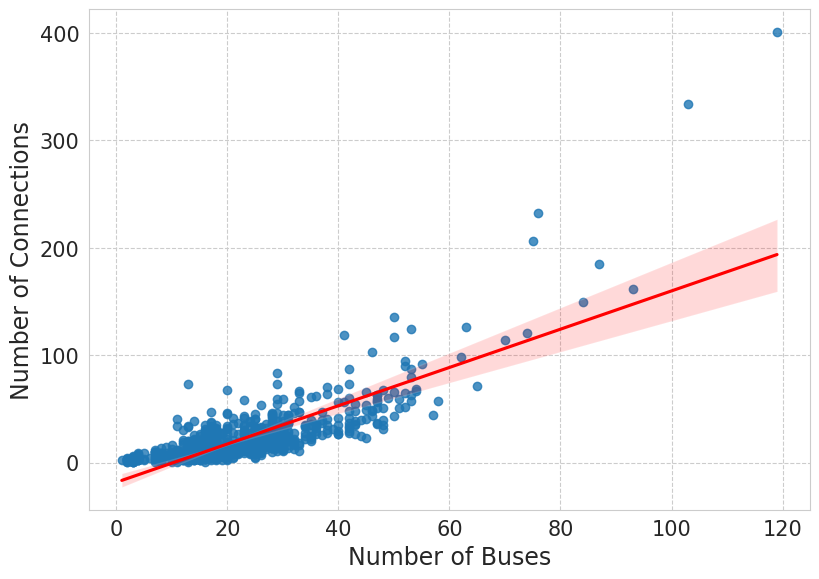

In [12]:
x = df_analise_edges.sample(n = 1000)
fig, axes = plt.subplots(figsize = (9.3, 6.5))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.regplot(x = x.min_bus_count, y = x.conn_count, ci = 95, ax = axes, line_kws = {'color': 'red'})
g.tick_params(labelsize = 15)
g.set_xlabel("Number of Buses", fontsize = 17)
g.set_ylabel("Number of Connections", fontsize = 17);

In [13]:
scipy.stats.pearsonr(x = x.min_bus_count, y = x.conn_count)

PearsonRResult(statistic=0.8108038580156005, pvalue=2.2396704632765147e-234)

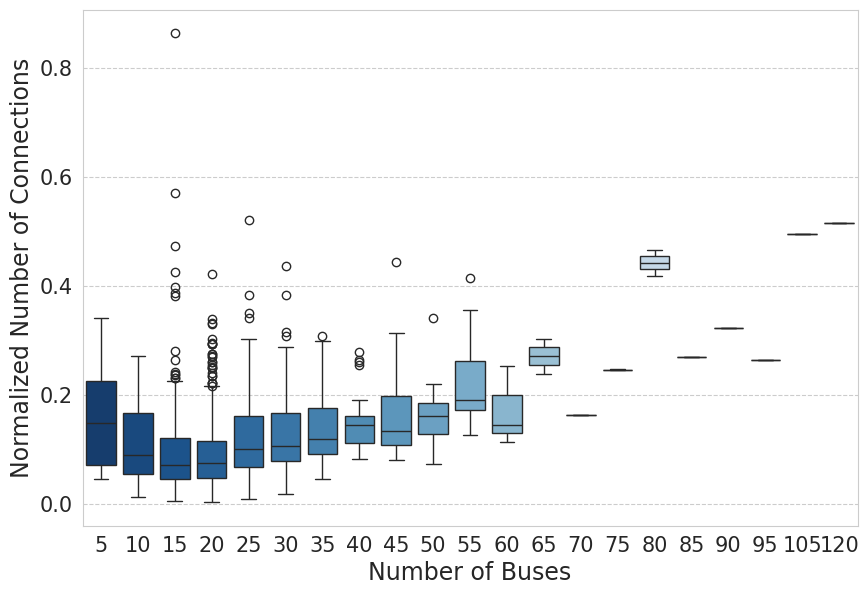

In [14]:
fig, axes = plt.subplots(figsize = (10, 6.7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
x['min_bus_count_group'] = 5 * (1 + x.min_bus_count / 5).astype('int32')
g = sns.boxplot(x = x.min_bus_count_group, y = x.conn_count_normalized, linewidth = 1.0, palette = sns.color_palette("Blues_r", len(x.min_bus_count_group.unique())), hue = x.min_bus_count_group, notch = False, showfliers = True, ax = axes, legend = False)
g.tick_params(labelsize = 15)
g.set_xlabel("Number of Buses", fontsize = 17)
g.set_ylabel("Normalized Number of Connections", fontsize = 17);

In [15]:
x.sort_values('conn_count_normalized', ascending = False).head(50)

,dummy_legacy_id_u,dummy_legacy_id_v,line_code_u,line_code_v,group_id,conn_count,bus_count_u,bus_count_v,min_bus_count,conn_count_normalized,min_bus_count_group
126307,109066,109066,X36,022,22166,73,13.0,128.0,13.0,0.863063,15
12072,108025,108213,302,550,4277,41,11.0,123.0,11.0,0.570785,15
11304,108213,108027,550,202,14083,68,123.0,20.0,20.0,0.520124,25
120924,109047,109046,023,022,20066,401,119.0,125.0,119.0,0.515441,120
54577,108037,108038,603,203,7211,334,132.0,103.0,103.0,0.495777,105
149026,140319,140612,338,474,97651,34,186.0,11.0,11.0,0.472277,15
68722,108080,108080,550,503,10973,232,125.0,76.0,76.0,0.466352,80
105516,108209,108210,350,550,13936,119,41.0,124.0,41.0,0.443102,45
69001,150202,109109,512,023,111744,83,29.0,121.0,29.0,0.436853,30
59256,108054,108054,X20,602,9410,39,14.0,92.0,14.0,0.425033,15


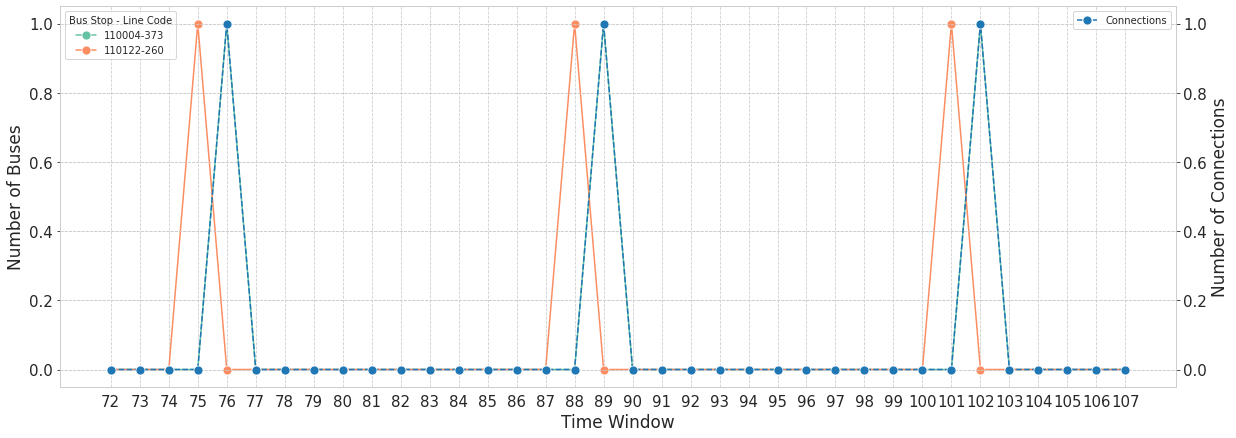

In [27]:
group_id = 52284
period = 'Morning'

edge_info = df_analise_edges.query(f"group_id == {group_id}")
if (edge_info['bus_count_u'] < edge_info['bus_count_v']).bool():
    minor_id = list(edge_info[['dummy_legacy_id_u', 'line_code_u']].itertuples(index=False, name=None))[0]
    bigger_id = list(edge_info[['dummy_legacy_id_v', 'line_code_v']].itertuples(index=False, name=None))[0]
else:
    minor_id = list(edge_info[['dummy_legacy_id_v', 'line_code_v']].itertuples(index=False, name=None))[0]
    bigger_id = list(edge_info[['dummy_legacy_id_u', 'line_code_u']].itertuples(index=False, name=None))[0]

ba = df_bus_availability.query(f"period == '{period}'").copy()
df0 = ba.query(f"(dummy_legacy_id == {minor_id[0]} and line_code == '{minor_id[1]}') or (dummy_legacy_id == {bigger_id[0]} and line_code == '{bigger_id[1]}')").copy()
df0['label'] = df0['dummy_legacy_id'].astype(str) + "-" + df0['line_code']
pe = positive_edges.query(f"period == '{period}' and group_id == {group_id} and duration >= {cd[0]} and duration <= {cd[1]}").copy()
pe['time_window'] = (60 * pe["event_timestamp_v"].dt.hour + pe["event_timestamp_v"].dt.minute).floordiv(tw)
df1 = pd.merge(df0.time_window.drop_duplicates(), pe.groupby('time_window').size().reset_index(name='conn_count'), how = 'left').fillna(0)

fig, axes = plt.subplots(figsize = (20, 7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g0 = sns.lineplot(x = df0.time_window, y = df0.bus_count, estimator = 'mean', errorbar = ('ci', 95), hue = df0.label, hue_order = ["%s-%s" % (minor_id[0], minor_id[1]), "%s-%s" % (bigger_id[0], bigger_id[1])], legend = True, palette = sns.color_palette("Set2", 2), marker = 'o', markersize = 9, linestyle = "solid",)
g0.tick_params(labelsize = 15)
g0.set_ylabel("Number of Buses", fontsize = 17)
g0.set_xlabel("Time Window", fontsize = 17)
g0.set_xticks(df0.time_window.drop_duplicates())
plt.legend(title = 'Bus Stop - Line Code', loc = 'upper left')

g1 = sns.lineplot(x = df1.time_window, y = df1.conn_count, marker = 'o', markersize = 9, linestyle = "dashed", ax = g0.axes.twinx(), label = 'Connections')
g1.tick_params(labelsize = 15)
g1.set_ylabel("Number of Connections", fontsize = 17);

# Ajustando a escala do eixo y
ymin = min(g0.get_ylim()[0], g1.get_ylim()[0])
ymax = max(g0.get_ylim()[1], g1.get_ylim()[1])

g0.set_ylim(ymin, ymax)
g1.set_ylim(ymin, ymax);

<h3>Build dataset to send to LSTM</h3>

In [18]:
def build_dataset(group_id):
    edge_info = df_analise_edges.query(f"group_id == {group_id}")
    if (edge_info['bus_count_u'] < edge_info['bus_count_v']).bool():
        minor_id = list(edge_info[['dummy_legacy_id_u', 'line_code_u']].itertuples(index=False, name=None))[0]
        bigger_id = list(edge_info[['dummy_legacy_id_v', 'line_code_v']].itertuples(index=False, name=None))[0]
    else:
        minor_id = list(edge_info[['dummy_legacy_id_v', 'line_code_v']].itertuples(index=False, name=None))[0]
        bigger_id = list(edge_info[['dummy_legacy_id_u', 'line_code_u']].itertuples(index=False, name=None))[0]
    minor_df = df_bus_availability.query(f"dummy_legacy_id == {minor_id[0]} and line_code == '{minor_id[1]}'").filter(['time_window', 'bus_count']).copy()
    minor_df['series'] = 'minor'
    bigger_df = df_bus_availability.query(f"dummy_legacy_id == {bigger_id[0]} and line_code == '{bigger_id[1]}'").filter(['time_window', 'bus_count']).copy()
    bigger_df['series'] = 'bigger'
    bus_count_df = pd.concat([minor_df, bigger_df], ignore_index = True)
    bus_count_df.rename({'bus_count': 'value'}, axis = 1, inplace = True)
    pe = positive_edges.query(f"group_id == {group_id} and duration >= {cd[0]} and duration <= {cd[1]}").copy()
    pe['time_window'] = (60 * pe["event_timestamp_v"].dt.hour + pe["event_timestamp_v"].dt.minute).floordiv(tw)
    pe_df = pd.merge(bus_count_df.time_window.drop_duplicates(), pe.groupby('time_window').size().reset_index(name='conn_count'), how = 'left').fillna(0)
    pe_df['series'] = 'connection'
    pe_df.rename({'conn_count': 'value'}, axis = 1, inplace = True)
    lstm_df = pd.concat([bus_count_df, pe_df], ignore_index = True)
    lstm_df['group_id'] = group_id
    return lstm_df

In [20]:
lstm_dfs = []
c = 0
for group_id in x.group_id:
    lstm_dfs.append(build_dataset(group_id))
    c = c + 1
    if (c % 100 == 0):
        print("%d / %d" % (c, len(x.group_id)))

100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
1000 / 1000


In [33]:
df = pd.concat(lstm_dfs)
df = df.pivot(index = ['agg_cluster_id', 'time_window'], columns = 'series', values = 'value').reset_index()
df.filter(['agg_cluster_id', 'time_window', 'minor', 'bigger', 'connection']).to_parquet('lstm_df.parquet', index = None)

In [34]:
pd.read_parquet('lstm_df.parquet')

series,group_id,time_window,minor,bigger,connection
0,307,72,0.0,0.0,0.0
1,307,73,0.0,1.0,0.0
2,307,74,1.0,0.0,1.0
3,307,75,0.0,1.0,0.0
4,307,76,0.0,0.0,0.0
...,...,...,...,...,...
167995,198662,235,1.0,0.0,0.0
167996,198662,236,0.0,0.0,0.0
167997,198662,237,0.0,1.0,1.0
167998,198662,238,0.0,0.0,0.0


In [46]:
df = pd.concat(lstm_dfs)

In [54]:
df['hour'] = (df.time_window * 5).floordiv(60)

In [68]:
df.query("agg_cluster_id == 8216 and series == 'minor' and 6 <= hour <= 8").sort_values('time_window').head(100)

,time_window,value,series,group_id,hour
0,72,1.0,minor,8216,6
11,73,1.0,minor,8216,6
49,74,0.0,minor,8216,6
139,75,1.0,minor,8216,6
52,76,1.0,minor,8216,6
119,77,1.0,minor,8216,6
31,78,0.0,minor,8216,6
47,79,1.0,minor,8216,6
73,80,1.0,minor,8216,6
118,81,1.0,minor,8216,6


<h3>Compute Cluster Metrics</h3>

In [76]:
bus_stop_clustered = pd.read_parquet('bus_stop_clustered.parquet')
df_cluster = pd.merge(df_analise_edges, bus_stop_clustered[['legacy_id', 'cluster']], left_on = 'dummy_legacy_id_u', right_on = 'legacy_id', how = 'inner')

<h4>Cluster Density</h4>

In [81]:
agg_cluster = df_cluster.groupby('cluster').agg({'group_id': 'nunique', 'conn_count': 'mean', 'conn_count_normalized': 'mean'}).reset_index()
mean, std, q1, median, q3 = agg_cluster.group_id.mean(), agg_cluster.group_id.std(), agg_cluster.group_id.quantile(0.25), agg_cluster.group_id.quantile(0.5), agg_cluster.group_id.quantile(0.75)
agg_cluster['mean'] = mean
agg_cluster['std'] = std
agg_cluster['q1'] = q1
agg_cluster['median'] = median
agg_cluster['q3'] = q3
conditions = [
    (agg_cluster.group_id <= agg_cluster['mean']),
    ((agg_cluster.group_id > agg_cluster['mean']) & (agg_cluster.group_id <= agg_cluster['mean'] + 2 * agg_cluster['std'])),
    (agg_cluster.group_id > agg_cluster['mean'] + 2 * agg_cluster['std'])]
density_choices = ['Low Density', 'Moderate Density', 'High Density']
agg_cluster['density'] = np.select(conditions, density_choices, default = 'N/A')

<h4>Cluster Efficiency</h4>

In [110]:
mean, std, q1, median, q3 = agg_cluster.conn_count_normalized.mean(), agg_cluster.conn_count_normalized.std(), agg_cluster.conn_count_normalized.quantile(0.25), agg_cluster.conn_count_normalized.quantile(0.5), agg_cluster.conn_count_normalized.quantile(0.75)
agg_cluster['mean'] = mean
agg_cluster['std'] = std
agg_cluster['q1'] = q1
agg_cluster['median'] = median
agg_cluster['q3'] = q3
multiplier = 0.8
conditions = [
    (agg_cluster.conn_count_normalized <= agg_cluster['median']),
    ((agg_cluster.conn_count_normalized > agg_cluster['median']) & (agg_cluster.conn_count_normalized <= agg_cluster['q3'] + multiplier * (agg_cluster['q3'] - agg_cluster['q1']))),
    (agg_cluster.conn_count_normalized > agg_cluster['q3'] + multiplier * (agg_cluster['q3'] - agg_cluster['q1']))]
efficiency_choices = ['Low Efficiency', 'Moderate Efficiency', 'High Efficiency']
agg_cluster['efficiency'] = np.select(conditions, efficiency_choices, default = 'N/A')

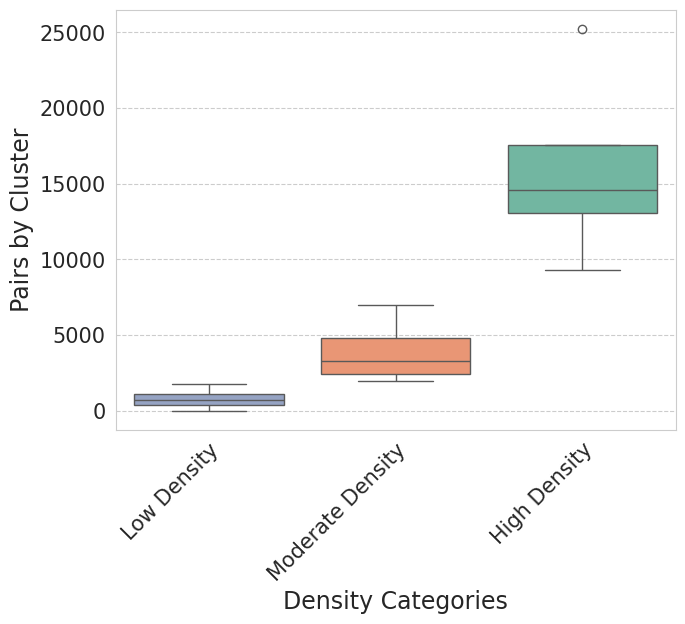

In [111]:
fig, axes = plt.subplots(figsize = (7, 7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.boxplot(x = agg_cluster.density, y = agg_cluster.group_id, hue = agg_cluster.density, order = density_choices, palette = sns.color_palette("Set2", 3))
g.tick_params(labelsize = 15)
g.set_xlabel("Density Categories", fontsize = 17)
g.set_ylabel("Pairs by Cluster", fontsize = 17)
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
plt.subplots_adjust(left = 0.15, right = 0.95, bottom = 0.35, top = 0.95)
#plt.savefig('../../../../Downloads/boxplot_density.png', format = 'png', dpi = 300);

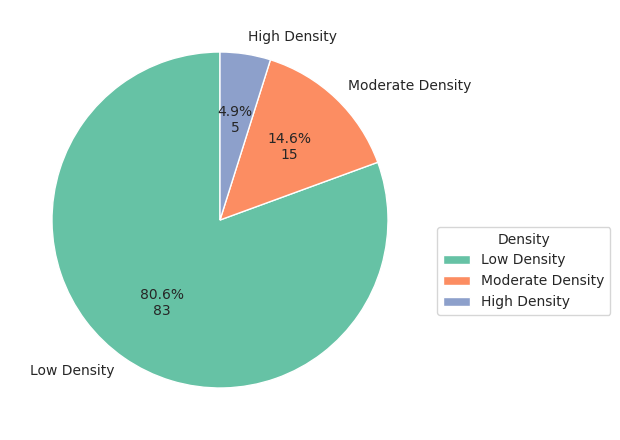

In [118]:
# Calculate the counts of each density category
density_counts = agg_cluster['density'].value_counts()

# Set colors for the pie chart using 'Set2' color palette
colors = sns.color_palette("Set2", len(density_counts))

# Create the pie chart
fig, ax = plt.subplots(figsize=(7, 7))
wedges, texts, autotexts = ax.pie(density_counts, labels=density_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)

# Add absolute counts to the pie chart
for i, autotext in enumerate(autotexts):
    autotext.set_text(f"{autotext.get_text()}\n{density_counts.iloc[i]}")

# Add title and legend
ax.legend(title="Density", loc="best", bbox_to_anchor=(1, 0.5))

# Adjust spacing and show the plot
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.35, top=0.95)
plt.show()

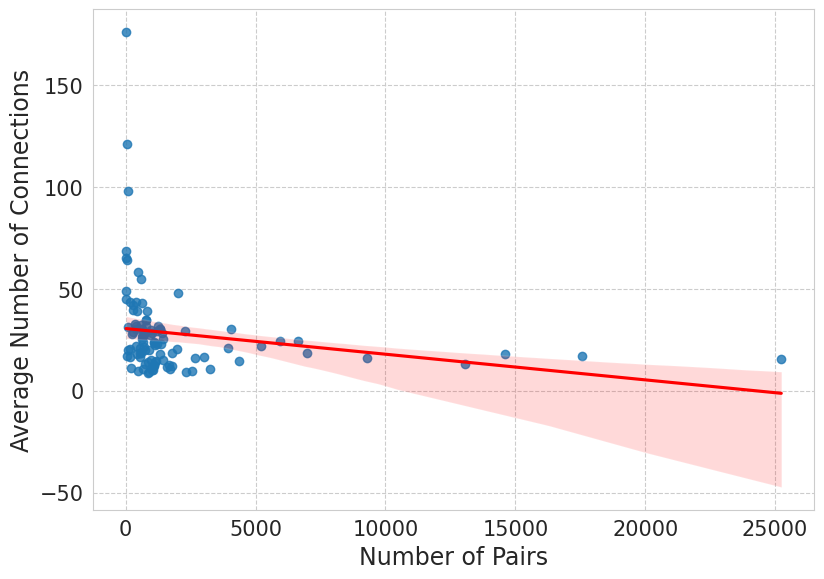

In [117]:
fig, axes = plt.subplots(figsize = (9.3, 6.5))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.regplot(x = agg_cluster.group_id, y = agg_cluster.conn_count, ci = 95, ax = axes, line_kws = {'color': 'red'})
g.tick_params(labelsize = 15)
g.set_xlabel("Number of Pairs", fontsize = 17)
g.set_ylabel("Average Number of Connections", fontsize = 17);

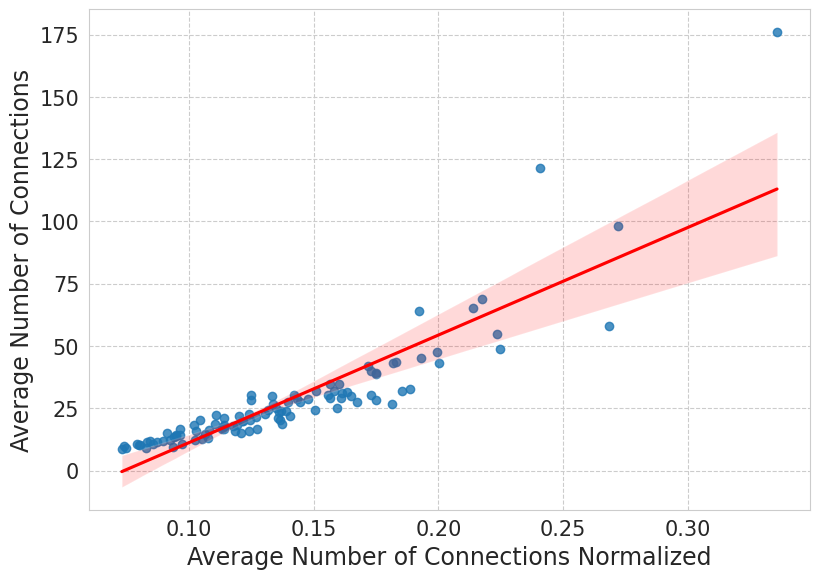

In [113]:
fig, axes = plt.subplots(figsize = (9.3, 6.5))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.regplot(x = agg_cluster.conn_count_normalized, y = agg_cluster.conn_count, ci = 95, ax = axes, line_kws = {'color': 'red'})
g.tick_params(labelsize = 15)
g.set_xlabel("Average Number of Connections Normalized", fontsize = 17)
g.set_ylabel("Average Number of Connections", fontsize = 17);

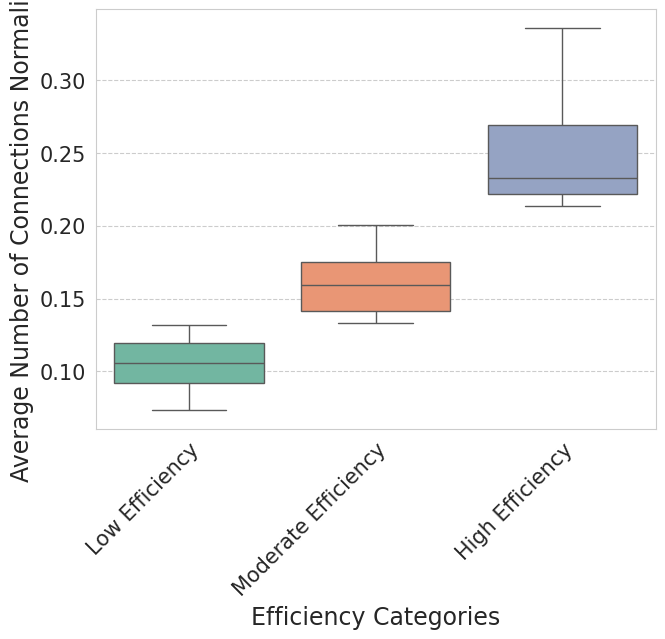

In [114]:
fig, axes = plt.subplots(figsize = (7, 7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.boxplot(x = agg_cluster.efficiency, y = agg_cluster.conn_count_normalized, hue = agg_cluster.efficiency, order = efficiency_choices, palette = sns.color_palette("Set2", 3))
g.tick_params(labelsize = 15)
g.set_xlabel("Efficiency Categories", fontsize = 17)
g.set_ylabel("Average Number of Connections Normalized", fontsize = 17)
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
plt.subplots_adjust(left = 0.15, right = 0.95, bottom = 0.35, top = 0.95)
#plt.savefig('../../../../Downloads/boxplot_density.png', format = 'png', dpi = 300);

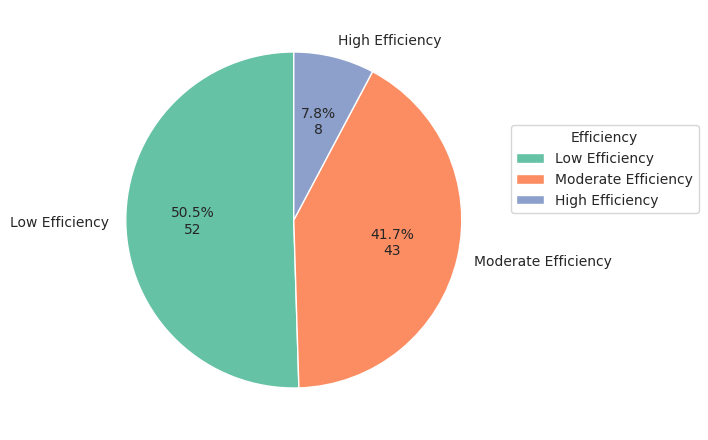

In [115]:
# Calculate the counts of each efficiency category
efficiency_counts = agg_cluster['efficiency'].value_counts()

# Set colors for the pie chart using 'Set2' color palette
colors = sns.color_palette("Set2", len(efficiency_counts))

# Create the pie chart
fig, ax = plt.subplots(figsize=(7, 7))
wedges, texts, autotexts = ax.pie(efficiency_counts, labels=efficiency_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)

# Add absolute counts to the pie chart
for i, autotext in enumerate(autotexts):
    autotext.set_text(f"{autotext.get_text()}\n{efficiency_counts.iloc[i]}")

# Add title and legend
ax.legend(title="Efficiency", loc="best", bbox_to_anchor=(1, 0.5))

# Adjust spacing and show the plot
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.35, top=0.95)
plt.show()

In [106]:
map_cluster = pd.merge(df_cluster, bs.filter(['dummy_legacy_id', 'latitude', 'longitude', 'name_normalized', 'type_norm']), left_on = 'dummy_legacy_id_u', right_on = 'dummy_legacy_id')
map_cluster.rename(columns = {'latitude': 'latitude_u', 'longitude': 'longitude_u', 'name_normalized': 'name_norm_u', 'type_norm': 'type_norm_u'}, inplace = True)
map_cluster.drop(columns = 'dummy_legacy_id', axis = 1, inplace = True)

map_cluster = pd.merge(map_cluster, bs.filter(['dummy_legacy_id', 'latitude', 'longitude', 'name_normalized', 'type_norm']), left_on = 'dummy_legacy_id_v', right_on = 'dummy_legacy_id')
map_cluster.rename(columns={'latitude': 'latitude_v', 'longitude': 'longitude_v', 'name_normalized': 'name_norm_v', 'type_norm': 'type_norm_v'}, inplace = True)
map_cluster.drop(columns = 'dummy_legacy_id', axis = 1, inplace = True)

<h3>Map by Cluster Density</h3>

In [108]:
mapa = folium.Map(
    location = [-25.4284, -49.2733],
    tiles = "OpenStreetMap",
    zoom_start = 12
)

markers = []
for density in density_choices:

    feature_group = folium.FeatureGroup(density)
    cluster_numbers = folium.FeatureGroup(f'Cluster Numbers ({density})')
    
    centers = []
    points = []    
    idx = list(agg_cluster.query(f"density == '{density}'").cluster.drop_duplicates())
    for index, conn in map_cluster.query(f"cluster == {idx}").filter(['latitude_u', 'longitude_u', 'name_norm_u', 'type_norm_u', 'latitude_v',
           'longitude_v', 'name_norm_v', 'type_norm_v', 'cluster']).drop_duplicates().iterrows():
        
        u = [conn['latitude_u'], conn['longitude_u']]
        v = [conn['latitude_v'], conn['longitude_v']]
        line = folium.PolyLine([u, v], color = 'red', weight = 1.0).add_to(feature_group)
        centre = bus_stop_clustered.query(f"centre == 1 and cluster == {conn['cluster']}").filter(['latitude', 'longitude']).values.tolist()[0]
        if centre not in centers:
            folium.Circle(centre, popup = conn["cluster"],
                radius = 600, color = 'blue', fill_color = 'blue', fill = True, opacity = 1, fill_opacity = 0.1, weight = 1.0).add_to(feature_group)
            folium.map.Marker(
                centre,
                icon=folium.DivIcon(
                    icon_size=(150,36),
                    icon_anchor=(0,0),
                    html='<div style="font-size: 12pt; font-weight: bold; color: black">%s</div>' % conn['cluster'],
                    )
                ).add_to(cluster_numbers)            
            centers.append(centre)
            
        if u not in points:
            markers.append(folium.Circle(u, popup = conn["name_norm_u"],
                radius = 3, color = 'black', fill_color = 'black', fill = True, opacity = 1, fill_opacity = 1, weight = 1.0).add_to(feature_group))
            points.append(u)
            
        if v not in points:
            markers.append(folium.Circle(v, popup = conn["name_norm_v"],
                radius = 3, color = 'black', fill_color = 'black', fill = True, opacity = 1, fill_opacity = 1, weight = 1.0).add_to(feature_group))
            points.append(v)
            
        mapa.add_child(feature_group)
        mapa.add_child(cluster_numbers)

folium.GeoJson(gpd.read_file('maps/PR_Municipios_2022.shp').query("NM_MUN == 'Curitiba'"),
             style_function=lambda x: {'color': 'black', 'fillOpacity': 0, 'weight': 1.5}).add_to(mapa)        
        
mapa.add_child(folium.LayerControl())
mapa.keep_in_front(*markers)
plugins.Fullscreen(                                                         
        position                = "topright",                                   
        title                   = "Open full-screen map",                       
        title_cancel            = "Close full-screen map",                      
        force_separate_button   = True,                                         
    ).add_to(mapa) 

mapa.save(outfile = "density_map.html")
web.open_new_tab("density_map.html")

False

<h3>Map by Cluster Density</h3>

In [116]:
mapa = folium.Map(
    location = [-25.4284, -49.2733],
    tiles = "OpenStreetMap",
    zoom_start = 12
)

markers = []
for efficiency in efficiency_choices:

    feature_group = folium.FeatureGroup(efficiency)
    cluster_numbers = folium.FeatureGroup(f'Cluster Numbers ({efficiency})')
    
    centers = []
    points = []    
    idx = list(agg_cluster.query(f"efficiency == '{efficiency}'").cluster.drop_duplicates())
    for index, conn in map_cluster.query(f"cluster == {idx}").filter(['latitude_u', 'longitude_u', 'name_norm_u', 'type_norm_u', 'latitude_v',
           'longitude_v', 'name_norm_v', 'type_norm_v', 'cluster']).drop_duplicates().iterrows():
        
        u = [conn['latitude_u'], conn['longitude_u']]
        v = [conn['latitude_v'], conn['longitude_v']]
        line = folium.PolyLine([u, v], color = 'red', weight = 1.0).add_to(feature_group)
        centre = bus_stop_clustered.query(f"centre == 1 and cluster == {conn['cluster']}").filter(['latitude', 'longitude']).values.tolist()[0]
        if centre not in centers:
            folium.Circle(centre, popup = conn["cluster"],
                radius = 600, color = 'blue', fill_color = 'blue', fill = True, opacity = 1, fill_opacity = 0.1, weight = 1.0).add_to(feature_group)
            folium.map.Marker(
                centre,
                icon=folium.DivIcon(
                    icon_size=(150,36),
                    icon_anchor=(0,0),
                    html='<div style="font-size: 12pt; font-weight: bold; color: black">%s</div>' % conn['cluster'],
                    )
                ).add_to(cluster_numbers)            
            centers.append(centre)
            
        if u not in points:
            markers.append(folium.Circle(u, popup = conn["name_norm_u"],
                radius = 3, color = 'black', fill_color = 'black', fill = True, opacity = 1, fill_opacity = 1, weight = 1.0).add_to(feature_group))
            points.append(u)
            
        if v not in points:
            markers.append(folium.Circle(v, popup = conn["name_norm_v"],
                radius = 3, color = 'black', fill_color = 'black', fill = True, opacity = 1, fill_opacity = 1, weight = 1.0).add_to(feature_group))
            points.append(v)
            
        mapa.add_child(feature_group)
        mapa.add_child(cluster_numbers)

folium.GeoJson(gpd.read_file('maps/PR_Municipios_2022.shp').query("NM_MUN == 'Curitiba'"),
             style_function=lambda x: {'color': 'black', 'fillOpacity': 0, 'weight': 1.5}).add_to(mapa)        
        
mapa.add_child(folium.LayerControl())
mapa.keep_in_front(*markers)
plugins.Fullscreen(                                                         
        position                = "topright",                                   
        title                   = "Open full-screen map",                       
        title_cancel            = "Close full-screen map",                      
        force_separate_button   = True,                                         
    ).add_to(mapa) 

mapa.save(outfile = "efficiency_map.html")
web.open_new_tab("efficiency_map.html")

False